# **An SIC Capstone project by Team Terrapix**

### **Importing essential libraries and defining the file paths**

In [2]:
#imports
import numpy as np
import pandas as pd

import os
import cv2
import datetime
import bs4
import time
import seaborn as sns
import matplotlib.pyplot as plt
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split


IMG_PATH = "C:/Users/raksh/OneDrive/Desktop/SAM/marine-debris-fls-datasets-master/md_fls_dataset/data/watertank-segmentation/Images"
MASK_PATH = "C:/Users/raksh/OneDrive/Desktop/SAM/marine-debris-fls-datasets-master/md_fls_dataset/data/watertank-segmentation/Masks"
PATH = "C:/Users/raksh/OneDrive/Desktop/SAM/marine-debris-fls-datasets-master/md_fls_dataset/data/watertank-segmentation/BoxAnnotations"
CSV_PATH = "C:/Users/raksh/OneDrive/Desktop/SAM/marine-debris-fls-datasets-master/md_fls_dataset/data/watertank-segmentation/all_annots.csv"
run_options = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom=True)


### **Image Preprocessing and Mask Application for Segmentation**

1. **Image Preprocessing**: The function `img_preproc` loads an image, applies resizing, erosion, and gradient transformations, and enhances lighter regions to improve contrast.
2. **Mask Creation and Application**: The function `mask_img_apply` loads, resizes, and applies a blue mask to the image to highlight segmented areas.
3. **Display Processed Images**: The code reads, processes, and visualizes the original grayscale image, the preprocessed image, and the masked image side-by-side for comparison.


(160, 160, 3) (160, 160, 3)


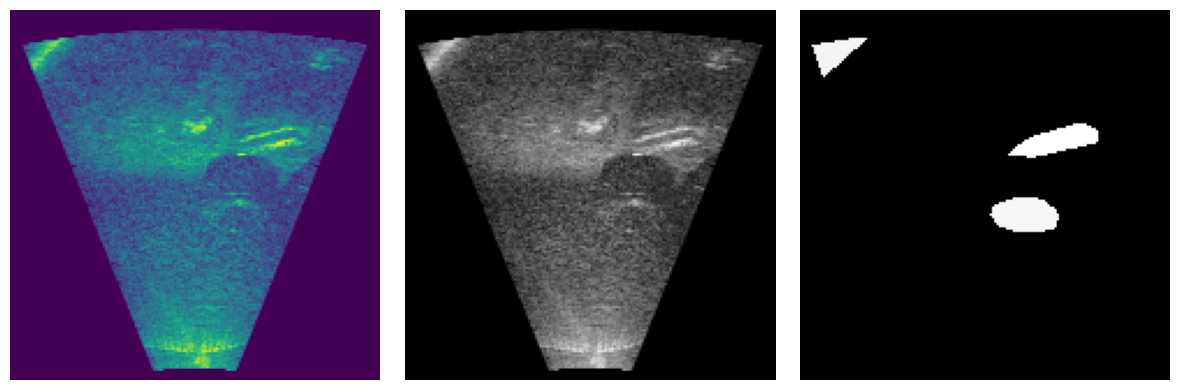

In [ ]:

s=160
def img_preproc(filename):
    x= cv2.imread(IMG_PATH+"/"+filename)
    x= cv2.resize(x,(s,s))
    kernel = np.ones((3,3), np.uint8)
    kernel2 = np.ones((1,1), np.uint8)
    kernel3 = np.ones((2,2), np.uint8)
    alpha = 1   # Contrast control (1.0-3.0)
    beta = 80   # Brightness control (0-100)
    
    return x 

def mask_img_apply(filename):
    #get mask img and apply to img
    x = cv2.imread(IMG_PATH+"/"+filename)
    x= cv2.resize(x,(s,s))
    
    mask= cv2.imread(MASK_PATH+"/"+filename)
    mask= cv2.resize(mask,(s,s))
    
    mask= cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask_color = (255, 255, 255)
    colored_mask = cv2.merge([mask * mask_color[0], mask * mask_color[1], mask * mask_color[2]])
    return colored_mask/255.

filename= "marine-debris-aris3k-139.png"
xg = cv2.imread(IMG_PATH+"/"+filename)
xg= cv2.cvtColor(xg, cv2.COLOR_BGR2GRAY)
xg= cv2.resize(xg,(s,s))
xg=xg/255.
#show the images
images = [xg,img_preproc(filename) , mask_img_apply(filename) ]
print(img_preproc(filename).shape, mask_img_apply(filename).shape)
# Create a figure and set up three subplots in a single row
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Display each image in its subplot
for ax, img in zip(axes, images):
    ax.imshow(img )
    ax.axis('off')  # Hide axes for each subplot

plt.tight_layout()
plt.show() 

marine-debris-aris3k-0.png


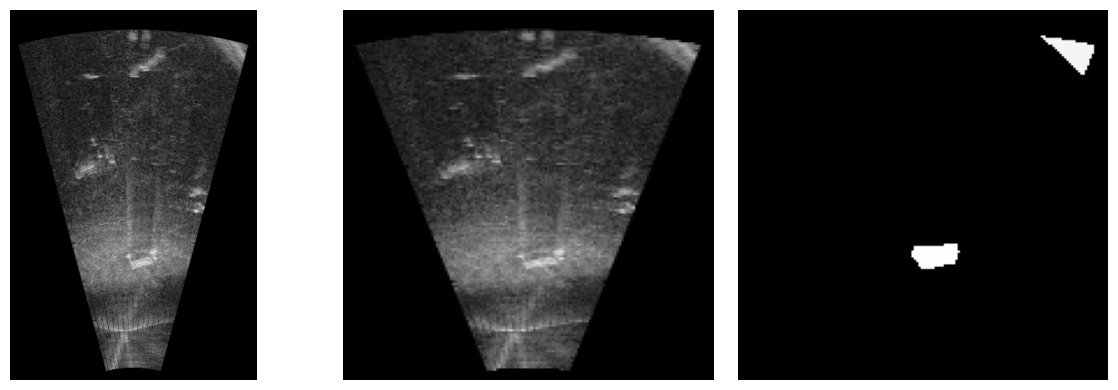

In [5]:
list_all_imgs = os.listdir(IMG_PATH) 
list_all_imgs.sort()
print(list_all_imgs[0])

def display_2_images(filename, img1, img2): 
    xg = cv2.imread(IMG_PATH+"/"+filename)
    
    images = [xg,img1, img2]
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    # Display each image in its subplot
    for ax, img in zip(axes, images):
        ax.imshow(img , cmap="gray")
        ax.axis('off')  # Hide axes for each subplot
    plt.tight_layout()
    plt.show() 
    

def load_data(image, type="image"):
       
    if type=="image":
        output_img= img_preproc(image)
        
    elif type == "mask":
        output_img = mask_img_apply(image)

    return np.array(output_img)

images = [load_data(i, "image") for i in list_all_imgs]
masks = [load_data(i, "mask") for i in list_all_imgs]

n = 4
display_2_images(list_all_imgs[n], images[n], masks[n])

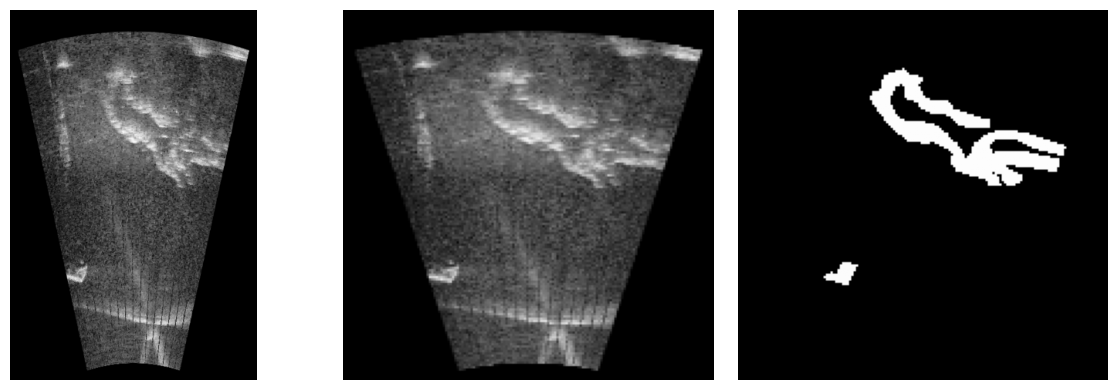

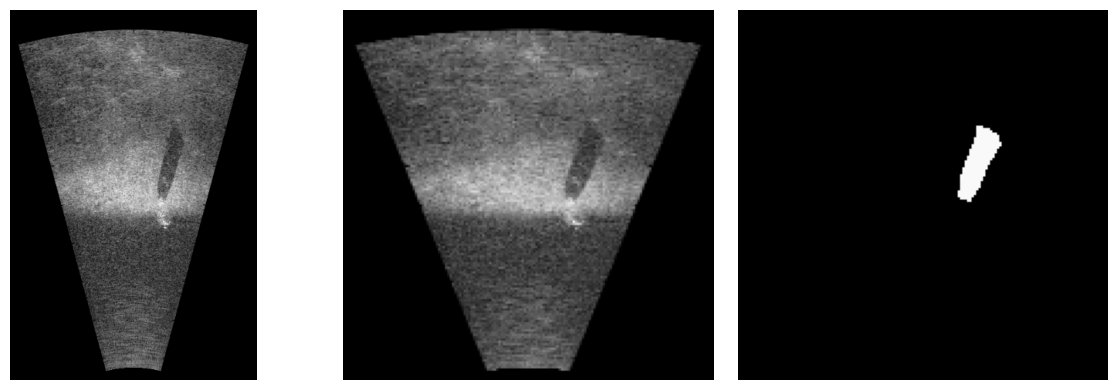

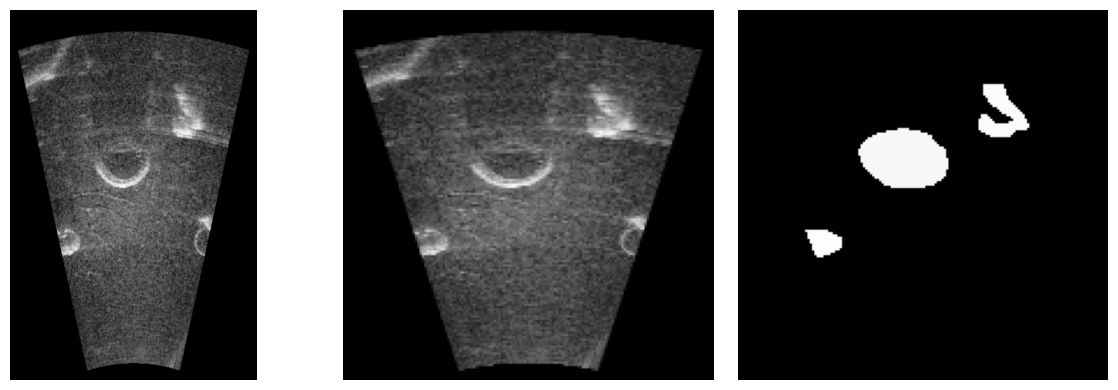

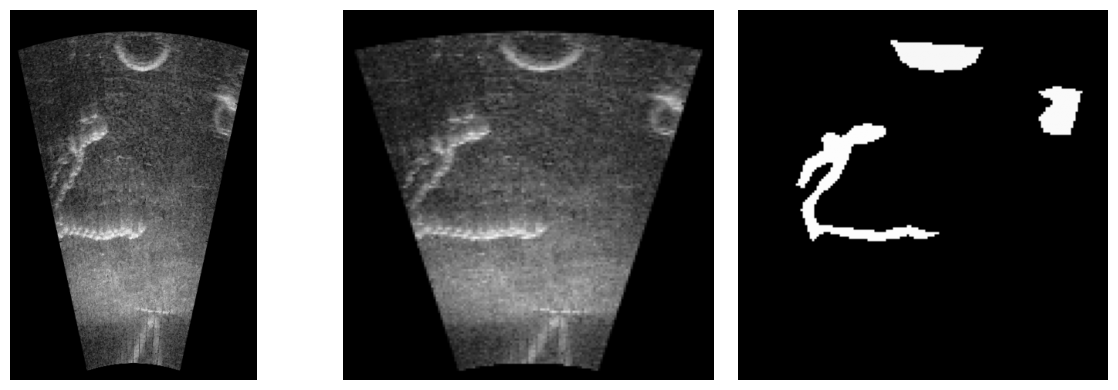

In [6]:
n = 4
for x in range(n):
     display_2_images(list_all_imgs[x+320], images[x+320], masks[x+320])


### **Data Preparation for Image Segmentation Model**

This code splits preprocessed images and masks into training, validation, and test sets (80%-10%-10%) and converts `y_train` and `y_val` mask data to grayscale if originally RGB.


In [7]:
images= np.array(images)
masks= np.array(masks)
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
# If y_train and y_val are RGB, convert to grayscale (single channel)
y_train = np.expand_dims(y_train[..., 0], axis=-1)  # Use only one channel, assuming all channels are identical
y_val = np.expand_dims(y_val[..., 0], axis=-1)

### **U-Net Model with VGG16 Backbone for Image Segmentation**

1. **VGG16 Backbone for Feature Extraction**: The model initializes with VGG16 as a backbone, loading pretrained ImageNet weights for improved feature extraction, and freezes these layers to retain learned features.
  
2. **Upsampling and Concatenation Layers**: It builds upsampling layers that use transposed convolutions to gradually increase spatial resolution, combining them with specific VGG16 layers via concatenation to preserve detailed spatial features.
  
3. **Binary Segmentation Output**: The model's final layer uses a 1x1 convolution with a sigmoid activation, creating a single-channel output suitable for binary segmentation.



In [9]:
from keras.models import Model
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Input
from keras.applications import VGG16

from keras.models import Model
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Input
from keras.applications import VGG16

def build_unet_model(input_shape):
    inputs = Input(shape=input_shape)
    base_VGG = VGG16(include_top=False, weights="imagenet", input_shape=input_shape)
    
    for layer in base_VGG.layers:
        layer.trainable = False
    
    bridge = base_VGG.get_layer("block5_conv3").output

    up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    concat_1 = concatenate([up1, base_VGG.get_layer("block4_conv3").output], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat_1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat_2 = concatenate([up2, base_VGG.get_layer("block3_conv3").output], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat_2)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    concat_3 = concatenate([up3, base_VGG.get_layer("block2_conv2").output], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat_3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    concat_4 = concatenate([up4, base_VGG.get_layer("block1_conv2").output], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat_4)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9) 

    # Updated output layer for binary segmentation
    conv11 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    model = Model(inputs=[base_VGG.input], outputs=[conv11])

    return model

# Example usage
input_shape = (160,160, 3)  # Input shape for RGB images (160x160)
unet_model = build_unet_model(input_shape)
# unet_model.summary()
s

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


160

In [10]:
from keras.metrics import MeanIoU
from keras.callbacks import ModelCheckpoint

unet_model.compile(loss = 'binary_crossentropy',metrics=['accuracy'], optimizer = keras.optimizers.Adam(learning_rate = 0.0001))

checkp = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = unet_model.fit(X_train, y_train, epochs = 40, batch_size = 16, validation_data = (X_val, y_val), callbacks = [checkp])

Epoch 1/40


c:\Users\raksh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1']. Received: the structure of inputs=*
  warnings.warn(


94/94 ━━━━━━━━━━━━━━━━━━━━ 765s 8s/step - accuracy: 0.9291 - loss: 1.5969 - val_accuracy: 0.9503 - val_loss: 0.2865
Epoch 2/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 527s 6s/step - accuracy: 0.9537 - loss: 0.2505 - val_accuracy: 0.9553 - val_loss: 0.1602
Epoch 3/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 494s 5s/step - accuracy: 0.9556 - loss: 0.1455 - val_accuracy: 0.9572 - val_loss: 0.1075
Epoch 4/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 557s 6s/step - accuracy: 0.9561 - loss: 0.1014 - val_accuracy: 0.9590 - val_loss: 0.0833
Epoch 5/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 805s 9s/step - accuracy: 0.9565 - loss: 0.0791 - val_accuracy: 0.9589 - val_loss: 0.0652
Epoch 6/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 597s 6s/step - accuracy: 0.9572 - loss: 0.0644 - val_accuracy: 0.9568 - val_loss: 0.0588
Epoch 7/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 627s 7s/step - accuracy: 0.9591 - loss: 0.0549 - val_accuracy: 0.9575 - val_loss: 0.0497
Epoch 8/40
81/94 ━━━━━━━━━━━━━━━━━━━━ 2:38 12s/step - accuracy: 0.9585 - loss: 0.0501

KeyboardInterrupt: 

### Saving the model

In [ ]:
datetime

# Get the current timestamp in YYYY_MM_DD format
timestamp = datetime.datetime.now().strftime("%Y_%m_%d")

# Define the model name with version and timestamp
model_name = f"unet_model_v1_{timestamp}.h5"

# Save the model
unet_model.save(model_name)

print(f"Model saved as: {model_name}")


Model saved as: unet_model_v1_2024_11_10.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step 


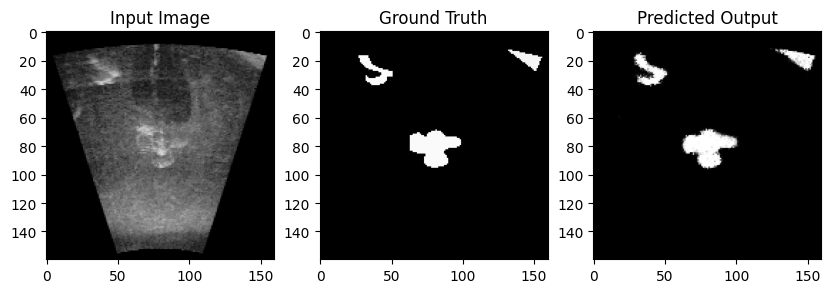

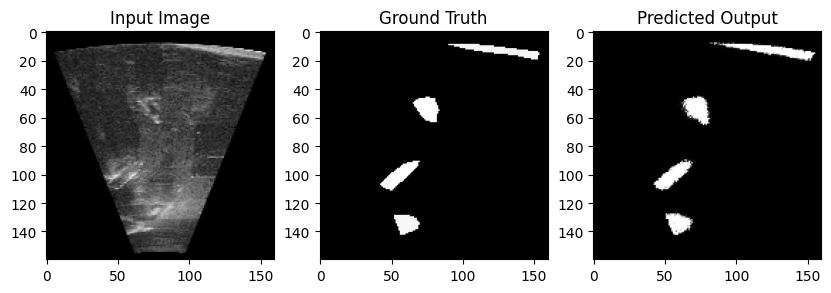

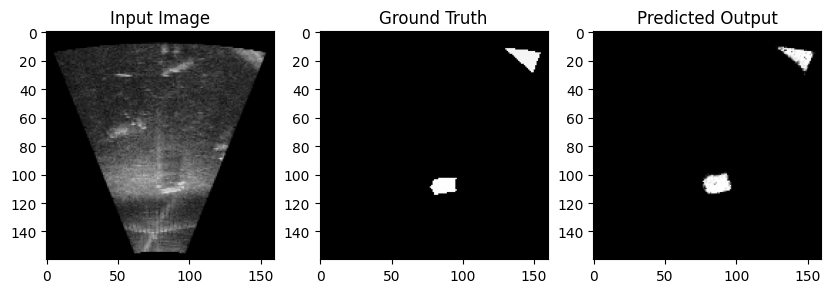

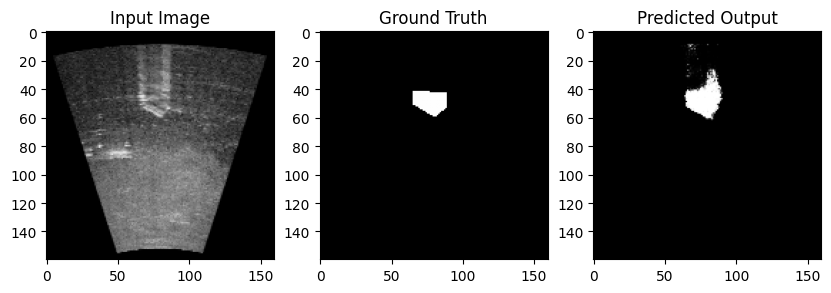

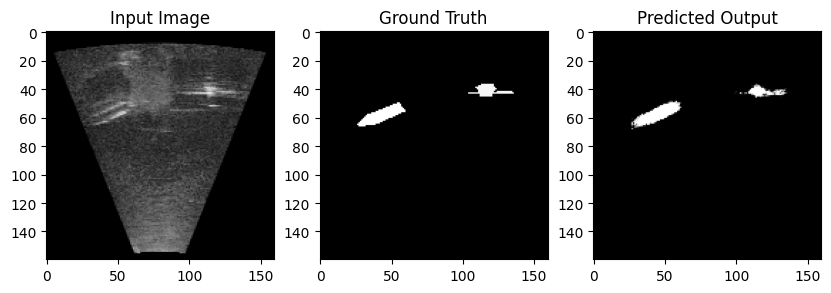

In [ ]:
import matplotlib.pyplot as plt

# Generate predictions
y_pred = unet_model.predict(X_test)  

# Display some sample predictions
for x in range(5):  # First 5 test samples
    plt.figure(figsize=(10, 4))

    # Display the input image
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[x])
    plt.title("Input Image")

    # Display the ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(y_test[x], cmap='gray')
    plt.title("Ground Truth")

    # Display the predicted mask (in grayscale)
    plt.subplot(1, 3, 3)
    plt.imshow(y_pred[x], cmap='gray')  # Directly use the predicted mask
    plt.title("Predicted Output")

    plt.show()


### **MODEL SUMMARY**

In [ ]:
from tensorflow.keras.models import load_model

# Load the pretrained UNet model
unet_model = load_model("unet_model_v1_2024_11_10.h5")

# Check the model architecture
unet_model.summary()



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 160, 160,  │      1,792 │ input_layer_3[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 160, 160,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 80, 80,    │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 80, 80,    │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 80, 80,    │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 40, 40,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 40, 40,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 40, 40,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 40, 40,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 20, 20,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 20, 20,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 20, 20,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 20, 20,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 10, 10,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 10, 10,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 10, 10,    │  2,359,808 │ block5_conv1[0][

 Total params: 25,854,659 (98.63 MB)

 Trainable params: 11,139,969 (42.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 2 (12.00 B)



### **Title: Dice Coefficient Evaluation for U-Net Model Predictions**

This code loads a saved U-Net model, generates predictions, and calculates the Dice coefficient to evaluate segmentation accuracy.


In [8]:
from keras.models import load_model
unet_model = load_model('unet_model_v1_2024_11_10.h5')

In [9]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

# Define the dice_coef function
def dice_coef(y_true, y_pred, smooth=1e-6):
    """
    Compute the Dice coefficient.
    Args:
        y_true: Ground truth masks (shape: [batch_size, height, width, 1]).
        y_pred: Predicted masks (shape: [batch_size, height, width, 1]).
        smooth: Smoothing factor to avoid division by zero.
    Returns:
        Dice coefficient (scalar value).
    """
    y_true_f = K.flatten(y_true)  # Flatten to 1D
    y_pred_f = K.flatten(y_pred)  # Flatten to 1D
    intersection = K.sum(y_true_f * y_pred_f)  # Compute intersection
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Load the saved model
unet_model = load_model('unet_model_v1_2024_11_10.h5', custom_objects={'dice_coef': dice_coef})

# Assuming y_test and X_test are already defined and contain the test ground truth and inputs
# Predict on X_test to get y_pred
y_pred = unet_model.predict(X_test)  # Predict on test data

# Ensure the predictions and ground truth masks have compatible types and shapes
y_pred = tf.cast(y_pred, tf.float32)
y_test = tf.cast(y_test, tf.float32)
y_test = y_test[..., 0:1]  # Ensure both are in shape [batch_size, height, width, 1]

# Compute Dice coefficient
dice_score = dice_coef(y_test, y_pred)
average_dice = K.eval(dice_score)  # Convert to scalar value if using TensorFlow backend

print(f"Dice Coefficient: {average_dice}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step
Dice Coefficient: 0.8571546077728271
